In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import sys
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

from collections import Counter

from scipy.stats import randint
from scipy.stats import randint

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [3]:
from price_transformer import PriceTransformer
from data_transformer import BaseDataTransformer
from feature_selection import GreedyFeatureSelection

-
- Year: Год выпуска или производства
- Model: Название или код модели автомобиля
- Car/Suv: Тип автомобиля (легковой автомобиль или внедорожник)
- Title: Название или описание автомобиля
- UsedOrNew: Состояние автомобиля (б/у или новый)
- Transmission: Тип трансмиссии (механическая или автоматическая)
- Engine: Объем двигателя или мощность (в литрах или киловаттах)
- DriveType: Тип привода (передний, задний или полный)
- FuelType: Тип топлива (бензин, дизель, гибрид или электричество)
- FuelConsumption: Потребление топлива (в литрах на 100 км)
- Kilometres: Пробег автомобиля (в километрах)
- ColourExtInt: Цвет автомобиля (внешний и внутренний)
- Location: Местонахождение автомобиля (город и штат)
- CylindersinEngine: Количество цилиндров в двигателе
- BodyType: Форма или стиль кузова автомобиля (седан, хэтчбек, купе и т.д.)
- Doors: Количество дверей в автомобиле
- Seats: Количество сидений в автомобиле

In [5]:
DATA_PATH ='../dataset/Australian_Vehicle_Prices.csv'

In [6]:
df = pd.read_csv(DATA_PATH)

In [7]:
df.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


Посмотрю сначала на то, какой размерности датасет, есть ли пропущенные значения в нем

In [9]:
df.shape

(16734, 19)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

Видим, что сечас все признаки кроме одного числового отображаются как категориалные

Рассмторим есть ли пропущенные значения в датасете

In [13]:
pd.DataFrame(zip(df.isna().sum(),100 * (df.isna().sum()/df.shape[0])),columns=['Количество пропущенных значений','Процент от общего числа строк (%)'], index=df.columns)

,Количество пропущенных значений,Процент от общего числа строк (%)
Brand,1,0.005976
Year,1,0.005976
Model,1,0.005976
Car/Suv,28,0.167324
Title,1,0.005976
UsedOrNew,1,0.005976
Transmission,1,0.005976
Engine,1,0.005976
DriveType,1,0.005976
FuelType,1,0.005976


- Видим, что в каждый из признаков исходного датасета содержит пропущенные значения
- Можно выделить признаки Doors, Seats как те, которые содержат большое количество пропущенных значений (около 10 процентов от датасета)

Посмотрим теперь сумму пропущенных значений по строкам датасета

In [16]:
missing_counts = df.isna().sum(axis=1)
missing_counts.sort_values(ascending=False)

2391     19
15802     4
15357     4
15351     4
15343     4
         ..
5905      0
5906      0
5907      0
5908      0
16733     0
Length: 16734, dtype: int64

- Видим, что есть строка у которой пропущеннs все значения
- Ее можно удалить , с остальными пропущенными значениями разбираться отдельно

In [18]:
df.iloc[2391]

Brand                NaN
Year                 NaN
Model                NaN
Car/Suv              NaN
Title                NaN
UsedOrNew            NaN
Transmission         NaN
Engine               NaN
DriveType            NaN
FuelType             NaN
FuelConsumption      NaN
Kilometres           NaN
ColourExtInt         NaN
Location             NaN
CylindersinEngine    NaN
BodyType             NaN
Doors                NaN
Seats                NaN
Price                NaN
Name: 2391, dtype: object

In [19]:
df = df.drop(2391)

Количество строк в датасете которые содержат хотя бы одно пропущенное значение

In [21]:
df[df.isna().sum(axis=1) > 0].shape[0]

2147

- Теперь, после проверки датасета на наличие явно неадекватных строк (все значения в строке пропущены)
Удаление которых не создает для нас никакого data leak
Приступаем к разделению данных на обучающее и и тестовые множество
и только после этого на обучающем множестве начинаем обработку данных

In [23]:
RANDOM_STATE = 42

In [24]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

- Рассмотрим переменную Brand. Еще раз проверим на наличие пропущенных значений.

In [26]:
train_df = df_train.copy()
train_df.Brand.isna().any()

False

In [27]:
train_df[train_df.Brand == '-']

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price


Пропущенных значений нет рассмотрим теперь количнство примеров для каждой из возможных категорий бренда

Видно, что есть категории содержащии большое количество примеров , а есть где он всего один

In [30]:
brand_counts = train_df.Brand.value_counts()
brand_counts

Brand
Toyota         2202
Hyundai         985
Mazda           940
Holden          855
Nissan          852
               ... 
Rolls-Royce       1
Datsun            1
Polestar          1
Packard           1
Lamborghini       1
Name: count, Length: 75, dtype: int64

- Рассмотррим без лейблов и процентов (чтобы не наслаивалось)  как примерно выглядит набор категорий (Брэндов) на круговой диаграмме, чтобы иметь представление в целом о характере категории

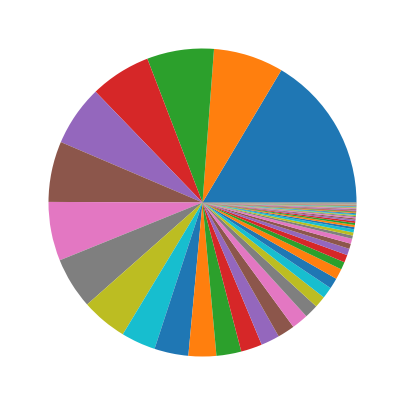

In [32]:
plt.figure(figsize=(15,5))
plt.pie(brand_counts)
plt.show()

- Видно, что есть большое количество категорий , имеющих маленькое количество примеров в датасеете, скорее всего часть таких "одиночек" попали  и в тестовую выборку

- Требуется создать новую категорию Other, куда собрать категории имеющих малое количесвто примеров в датасете. Однако точно сказать какой порог оптимален нельзя. Нужно будет подобрать на валидационной выборке оптимальное значение параметра который оприделяет порог разбиения.

- Рассмотрим зависимую переменную Price

In [36]:
train_df.Price.isna().any()

True

In [37]:
train_df.Price.info()

<class 'pandas.core.series.Series'>
Index: 13386 entries, 7594 to 15796
Series name: Price
Non-Null Count  Dtype 
--------------  ----- 
13385 non-null  object
dtypes: object(1)
memory usage: 209.2+ KB


In [38]:
train_df.Price.head()

7594     30990
10634    14999
4411     29995
12403    29999
9982     23750
Name: Price, dtype: object

Виден тип данных object, хотя судя по всему должен быть int/float
Проверим все ли значения могут быть числовыми

In [40]:
numeric_values = pd.to_numeric(train_df.Price, errors='coerce')
non_numeric_mask = pd.isnull(numeric_values)
non_numeric_values = train_df.Price[non_numeric_mask]
non_numeric_values.head()

16424    POA
15955    POA
16366    POA
15310    POA
16379    POA
Name: Price, dtype: object

Видим одно и тоже значение - POA. В гугле говорится что это значит - цена доступна при обращении  

In [42]:
non_numeric_values.shape

(38,)

Строки с таким значением целевой перменной можно удалить

In [44]:
train_df = train_df.drop(non_numeric_values.index)

train_df['Price'] = train_df['Price'].astype(float)

In [45]:
train_df['Price'].describe()

count    1.334800e+04
mean     3.725519e+04
std      3.714690e+04
min      8.800000e+01
25%      1.899900e+04
50%      2.950000e+04
75%      4.399000e+04
max      1.500000e+06
Name: Price, dtype: float64

Text(0.5, 0, 'Price')

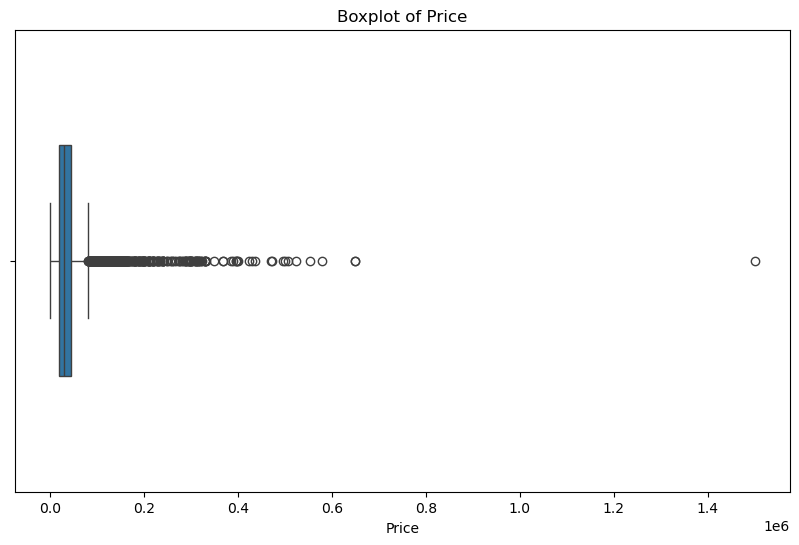

In [46]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='Price', data=train_df, width=0.5)

plt.title('Boxplot of Price')
plt.xlabel('Price')

Видно что есть выбросы , в частоности один с очень большой ценой, следует предусмотреть возможность при обработке как оставить без изменений датсет на трейне так и обрезать выбросы. Выбрать в зависимости от резуьтатов на валидации

In [48]:
Q1 = train_df['Price'].quantile(0.05)
Q3 = train_df['Price'].quantile(0.95)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df = train_df[(train_df['Price'] >= lower_bound) & (train_df['Price'] <= upper_bound)]

In [49]:
train_df.shape

(13242, 19)

- Рассмотрим переменную Year

In [51]:
train_df[train_df.Year == '-']

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price


In [52]:
count_year = train_df.Year.value_counts().sort_index()

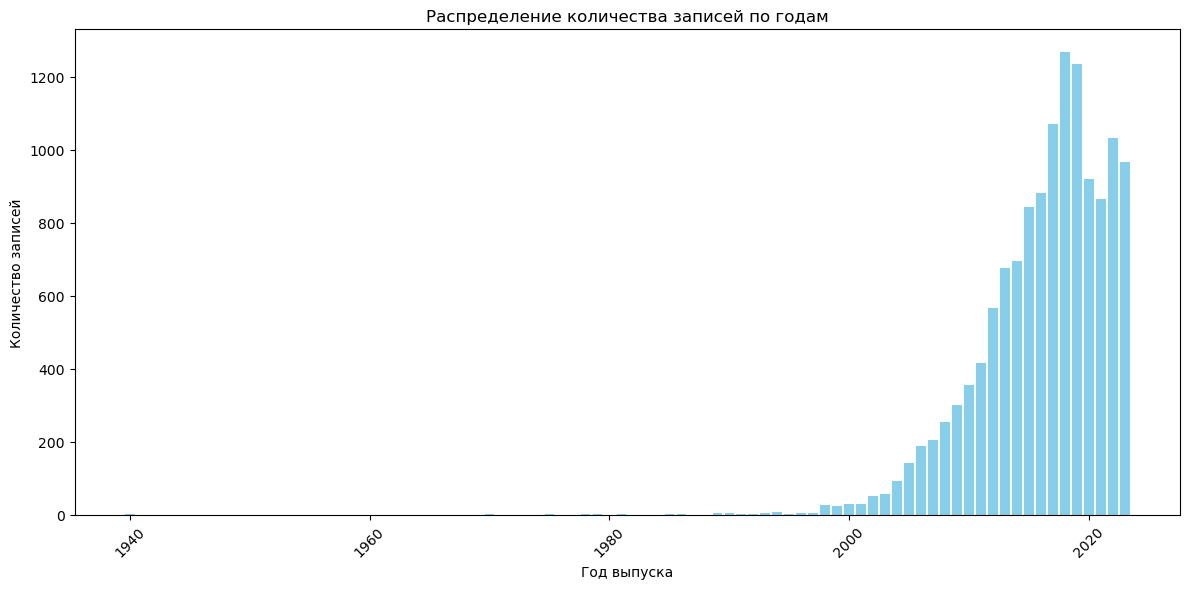

In [53]:
plt.figure(figsize=(12, 6))
plt.bar(count_year.index, count_year.values, color='skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Количество записей')
plt.title('Распределение количества записей по годам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Истерсно, что ярко выражен спад количеств записей с машинами годом выпуска 2020 и 2021 годы - в это время была эпидемия covid, разрыв цепочек и заводы выпустили мало авто

Оставим его использование напрямую как числвого признака , как тенденцию влияния старости или новизны на целевую переменную

In [56]:
train_df[['Price','Year']].corr()

,Price,Year
Price,1.000000,0.505679
Year,0.505679,1.000000


- Рассмотрим признак Model

In [58]:
train_df[train_df.Model == '-']

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price


In [59]:
model_counts = df.Model.value_counts()
model_counts

Model
Hilux          430
Corolla        405
Ranger         398
Landcruiser    370
I30            366
              ... 
Celerio          1
R-Class          1
Vectra           1
ES300            1
120              1
Name: count, Length: 781, dtype: int64

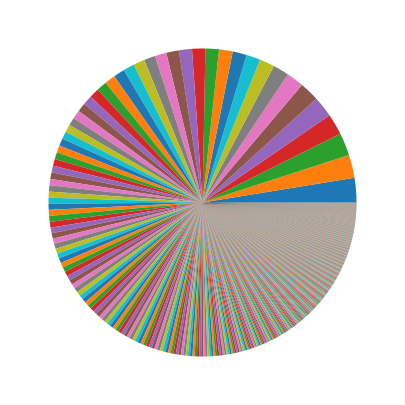

In [60]:
plt.figure(figsize=(15,5))
plt.pie(model_counts)
plt.show()

Аналогично, обьединять редкие категории в одну общую - порог подобрать на кросс валидации

-Рассмотрим переменнуб Car/Suv

Переменная Car/Suv содержит много данных которые зашумлены , встречаются как названия автосалонов , так и просто набор символов (*****) (похоже на вин номер)

Стоит отметить что в основном , наиболее частные категории соответвуют адеватным обозначениям типа кузова автомобиля


In [64]:
train_df.shape

(13242, 19)

In [65]:
(train_df['Car/Suv'] == train_df['BodyType']).sum()

10775

In [66]:
(train_df['Car/Suv'] != train_df['BodyType']).sum()

2467

Однако, есть важный момент можно заметить что часто совпадают колокнки BodyType и Car/Suv, в БоdyType более осмысленно заполнено.
Можно исопльзовать значения в колонке Car/Suv, на случай если в колонке Car/Suv пропущенны значения (None или "-")

In [68]:
train_df[train_df['BodyType'] == '-']

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price


In [69]:
train_df.BodyType.value_counts()

BodyType
SUV             5485
Hatchback       2168
Ute / Tray      2013
Sedan           1542
Wagon            976
Commercial       477
Coupe            239
Convertible       87
People Mover      17
Other             16
Name: count, dtype: int64

Посмотрим, какие значения принимает car/suv в случае когда BodyType Null

In [71]:
difference_df = train_df.loc[(train_df['Car/Suv'] != train_df['BodyType']) & ( train_df['BodyType'].isnull())][['Car/Suv','BodyType']]
difference_df.head()

,Car/Suv,BodyType
7594,USED Dealer ad,NaN
15832,USED Dealer ad,NaN
4210,USED Dealer ad,NaN
274,USED Dealer ad,NaN
4295,USED Dealer ad,NaN


In [72]:
difference_df.shape

(222, 2)

Всего 222 строк с NAN в BodyType, посмотрим какие категории в Car/Suv соответствуют им и в каком количестве

In [74]:
difference_df.BodyType = difference_df.BodyType.isnull()
difference_df.groupby('Car/Suv').count()

,BodyType
Car/Suv,
02 **** ****\n,14
03 **** ****\n,26
07 **** ****\n,3
08 **** ****\n,4
USED Dealer ad,165


Видно, что значения Used Dealer ad очень часто встречается при значениях NAN в колонке BodyType
Можно исопльзовать исходные категории прееменной BodyTypе плюс еще две категории где значение в колонке BodyType nan : Used dealer ad  и строковое значение содержащее "**** ****" обьядиняющее в себя все возможные вариации такой строки


Колонку же Car/Suv можно не использовать , мы из нее получили необходимую инфрмацию чтобы заполнить пропущенные данные в колонке в Колонке BodyTYpe которая более информативна

- Рассмотрим признак UsedOrNew

In [78]:
train_df['UsedOrNew'].isnull().any()

False

In [79]:
train_df['UsedOrNew'].value_counts()

UsedOrNew
USED    11939
NEW       895
DEMO      408
Name: count, dtype: int64

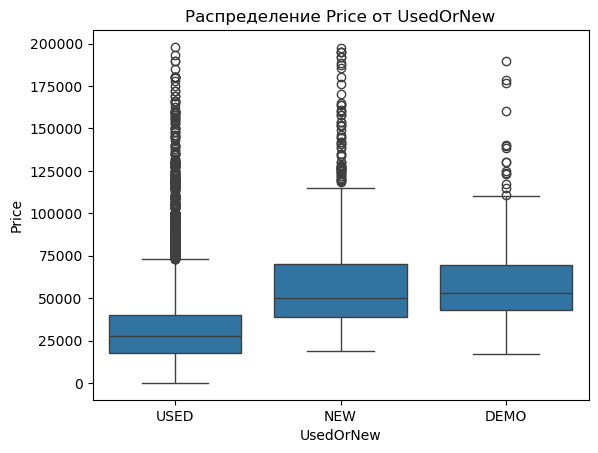

In [80]:
sns.boxplot(x='UsedOrNew', y='Price', data=train_df)
plt.xlabel('UsedOrNew')
plt.ylabel('Price')
plt.title('Распределение Price от UsedOrNew')
plt.show()

Для New и DEMO распределения имеют схожесть, медины значительно ближе друг к другу в отличие от USED

Видно, что с этим признаком все хорошо, есть три логичных категории , основная часть это модели с пробегом

Рассмотрим теперь FuelType

In [84]:
train_df['FuelType'].value_counts()

FuelType
Unleaded    5576
Diesel      3867
Premium     2652
-            507
Hybrid       499
Electric      92
Other         34
LPG           12
Leaded         3
Name: count, dtype: int64

Оставим '-' как отдельную категорию , с ней имеется приличное количество примеров в датасете.
Погуглил что такое LPG и Leaded
- LPG - тип аккумулятора можно отнести к Electric
- Leaded - присадка к топливу можно отнести к Premium


- Рассмотрим признак Transmission

In [87]:
train_df.Transmission.value_counts()

Transmission
Automatic    11474
Manual        1564
-              204
Name: count, dtype: int64

Видим три категории , категорию '-' можно заменить модой так как очень сильно превалирует категория automatic

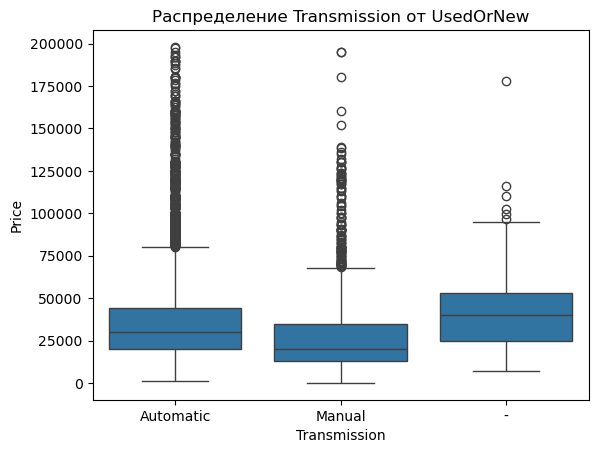

In [89]:
sns.boxplot(x='Transmission', y='Price', data=train_df)
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.title('Распределение Transmission от UsedOrNew')
plt.show()

- Расмотрим признак Kilometres

In [91]:
train_df.Kilometres.isna().any()

False

Хотя и пропущенных значений нет , имеются значения '-' и '- / -' которые необходимо заменить


In [93]:
train_df[(train_df.Kilometres == '-') | (train_df.Kilometres == '- / -')].Kilometres.count()

405

Будем заменять пропущенные значения медианными

In [95]:
train_df[(train_df.Kilometres != '-') & (train_df.Kilometres != '- / -')].Kilometres.astype(int).median()

86143.0

- Рассмотрим переменную FuelConsumption

Приведем к числовым значениям там где это возможно, после чего заполним пропущенные значения

In [98]:
train_df.FuelConsumption.isna().any()

False

In [99]:
train_df.FuelConsumption = train_df.FuelConsumption.apply(lambda x: float(x.split('L')[0]) if x and x != '-' else np.nan)

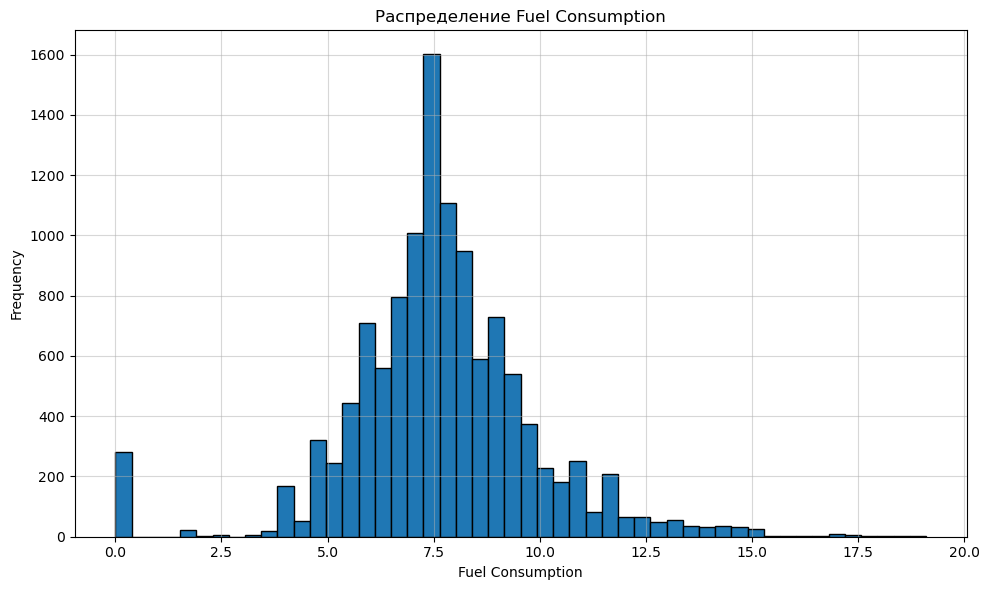

In [100]:
plt.figure(figsize=(10, 6))

train_df.FuelConsumption.hist(bins=50, edgecolor='black', linewidth=1)  # Настроить границы столбцов

plt.xlabel('Fuel Consumption')
plt.ylabel('Frequency')
plt.title('Распределение Fuel Consumption')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()


In [101]:
train_df.FuelConsumption.isna().sum()

1334

Видим приличное количество значений 0 и близко к этому при расходе топлива - это не выброс , это иза электромобилей и гибридных авто

In [103]:
train_df[train_df.FuelConsumption.isna()].head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
7594,Mazda,2019.0,3,USED Dealer ad,2019 Mazda 3,USED,Automatic,-,Front,Unleaded,NaN,18664,Red / 2019/05,"Dandenong South, VIC",-,NaN,NaN,NaN,30990.0
12403,LDV,2020.0,V80,Qld 4x4 Pty Ltd,2020 LDV V80 HIGH ROOF LONG WHEEL,USED,Automatic,-,Other,Diesel,NaN,61972,White / -,"Baringa, QLD",-,Commercial,NaN,NaN,29999.0
15832,BMW,1975.0,2002,USED Dealer ad,1975 BMW 2002,USED,Automatic,-,Rear,Leaded,NaN,110306,Green / Cream Cloth,"Rozelle, NSW",-,NaN,NaN,NaN,39990.0
12387,Nissan,2015.0,Navara,Qld 4x4 Pty Ltd,2015 Nissan Navara ST,USED,Manual,-,Other,Diesel,NaN,169969,Black / -,"Baringa, QLD",-,Ute / Tray,NaN,NaN,29999.0
16690,Mercedes-Benz,2013.0,Sprinter,M & G Motors,2013 Mercedes-Benz Sprinter 313 CDI,USED,Automatic,-,Other,-,NaN,339589,White / -,"Braybrook, VIC",-,Commercial,NaN,NaN,19988.0


- Расмсмотрим в паре две признака - Engine и CylindersinEngine.
Видно что они свзаны  между собой - первое занчение в Engine - это и есть значение CylindersinEngine

In [105]:
train_df[['Engine','CylindersinEngine']].head()

,Engine,CylindersinEngine
7594,-,-
10634,"4 cyl, 1.5 L",4 cyl
4411,"4 cyl, 2.2 L",4 cyl
12403,-,-
9982,"4 cyl, 2 L",4 cyl


In [106]:
(train_df.Engine.apply(lambda x: x.split(',')[0]) == train_df.CylindersinEngine).sum()

13242

Поэтому используем только второе значение у Engine

In [108]:
train_df.Engine

7594                -
10634    4 cyl, 1.5 L
4411     4 cyl, 2.2 L
12403               -
9982       4 cyl, 2 L
             ...     
11285    4 cyl, 2.5 L
11965               -
5391     4 cyl, 2.8 L
860        4 cyl, 2 L
15796               -
Name: Engine, Length: 13242, dtype: object

In [109]:
train_df.CylindersinEngine.value_counts()

CylindersinEngine
4 cyl     9184
6 cyl     1627
-         1319
8 cyl      444
5 cyl      315
3 cyl      258
0 L         85
12 cyl       5
2 cyl        3
10 cyl       1
2 L          1
Name: count, dtype: int64

- Для CylindersinEngine заменим на категорию с прочерком все цилиндры и значения которых мало меньше 86

Получим второе значение из признака Engine

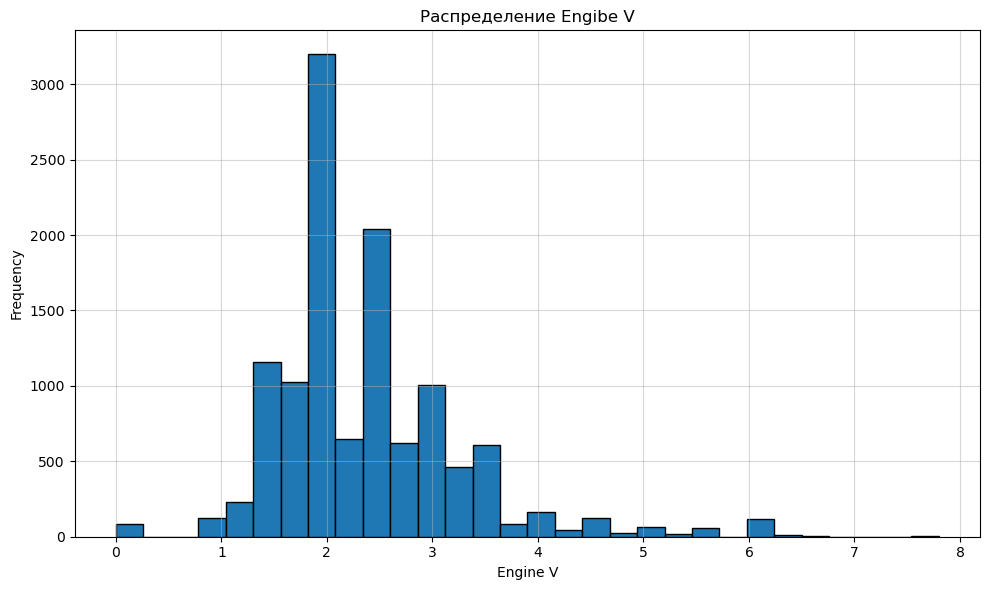

In [112]:
def extract_liters(value):
    match = re.search(r'(\d+\.?\d*) L', value)
    return float(match.group(1)) if match else np.nan
engine_vals = train_df.Engine.apply(extract_liters)
plt.figure(figsize=(10, 6))

engine_vals.hist(bins=30, edgecolor='black', linewidth=1)

plt.xlabel('Engine V')
plt.ylabel('Frequency')
plt.title('Распределение Engibe V')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()

In [113]:
engine_vals.isna().sum()

1320

In [114]:
engine_vals

7594     NaN
10634    1.5
4411     2.2
12403    NaN
9982     2.0
        ... 
11285    2.5
11965    NaN
5391     2.8
860      2.0
15796    NaN
Name: Engine, Length: 13242, dtype: float64

Опять же отталкиваясь от категории, если электричка то 0(медиана среди электрических авто), если гибрид медиана среди гибридов все остальное медиана среди омтальных категорий


- Рассмотрим DriveType

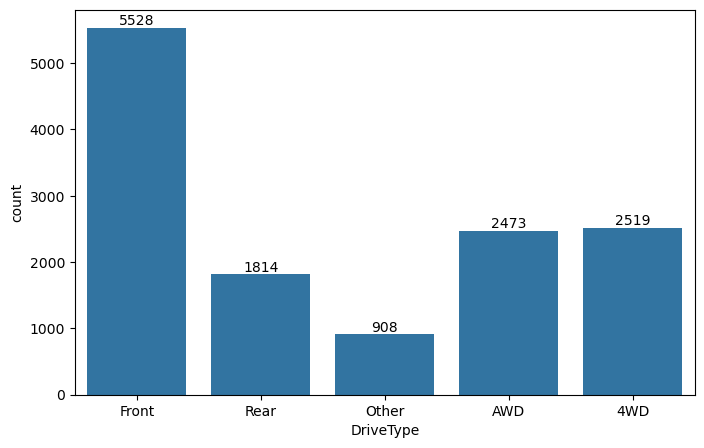

In [117]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=train_df, x='DriveType')
for i in ax.containers:
    ax.bar_label(i,)

plt.show()

Категориальная переменная без пропущенных и каких либо значений

- Рассмотрим переменную ColourExtInt.
Выберем первую часть цвета , несущую основную информацию

In [120]:
train_df.ColourExtInt.apply(lambda x: x.split(' / ')[0]).value_counts()

ColourExtInt
White        4765
Silver       1830
Grey         1820
Black        1542
Blue         1252
Red           887
-             310
5 years       204
Green         131
Brown         113
Gold          107
Orange         85
Yellow         64
3 years        48
6 years        22
7 years        20
4 years         8
Beige           8
Purple          8
Burgundy        7
Bronze          6
1 years         2
Pink            1
Cream           1
Turquoise       1
Name: count, dtype: int64

In [121]:
train_df.ColourExtInt.apply(lambda x: x.split(' / ')[1]).value_counts()

ColourExtInt
-                          6165
Black                      3803
Grey                       1147
Cloth                       241
Black Leather               238
                           ... 
Grey/Black                    1
Ebony Mason                   1
2017/07                       1
2021/05                       1
Black Synthetic Leather       1
Name: count, Length: 385, dtype: int64

Категории у которых указывается все что связано с годом (не понятно почему, но категрия получается более 300 примеров) соберем в одну категорию Other

- Title

Рассмотрим признак который характеризует полное название авто, он в себе содержит части из столбцов таблицы рассмотренных ранее проверим есть ли что то еще информативное в нем
- Уберем первые три слова в описании - это в основном известная информация , посмотрим встречается лм еще что то часто похожее не признак, Обычно важна не только модель машины но и еще ее шильдик (sport,quattro)
- Посмотрим, что в основном выводится после как дополнительные указания к модели

In [126]:
def remove_first_three_words(text):
    return ' '.join(text.split()[3:]) if len(text.split()) > 3 else ''

train_df['Title'].apply(remove_first_three_words)

7594                          
10634                     Maxx
4411     XL 2.2 HI-Rider (4X2)
12403     HIGH ROOF LONG WHEEL
9982                    Active
                 ...          
11285            Luxury Hybrid
11965                       MD
5391                 PRO (4X4)
860                        NEO
15796                   G10+21
Name: Title, Length: 13242, dtype: object

Видны уже известные категории по типу привода авто (4x4) и тд, также надо удалить знаечния через точку и числа просто, они не информативные это может быть например литраж двигателя который есть в другой переменной

In [128]:
def remove_words_in_parentheses(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\b\d+\.\d+\b', '', text)
    text = re.sub(r'\b\d+', '', text)
    return text


temp = train_df['Title'].apply(remove_first_three_words)
temp = temp.apply(remove_words_in_parentheses)

all_words = ' '.join(temp).split()

word_counts = Counter(all_words)

top_words = word_counts.most_common(15)
print("Самые часто встречающиеся слова:")
for word, count in top_words:
    print(f"{word}: {count}")

Самые часто встречающиеся слова:
Sport: 791
S: 541
Active: 454
TSI: 425
Hybrid: 363
ST: 344
Ascent: 330
Seat: 276
GXL: 275
LS: 256
GT: 241
Tfsi: 225
Premium: 218
TDI: 217
Quattro: 217


In [129]:
list(map(lambda x: x[0],top_words))

['Sport',
 'S',
 'Active',
 'TSI',
 'Hybrid',
 'ST',
 'Ascent',
 'Seat',
 'GXL',
 'LS',
 'GT',
 'Tfsi',
 'Premium',
 'TDI',
 'Quattro']

Будем использовать найденные категории просто как дополнительные бинарные признаки (есть ли в строке Title (1) или нет(0)). В ходе кросс валидации определим оптимальное их количество.

- Рассмотрим Location

In [132]:
train_df.Location.value_counts()

Location
Minchinbury, NSW         426
Blacktown, NSW           224
Liverpool, NSW           212
Hoppers Crossing, VIC    183
Bentley, WA              170
                        ... 
Wellington, NSW            1
Coomera, QLD               1
West Tamworth, NSW         1
Collie, WA                 1
Goodwood, SA               1
Name: count, Length: 606, dtype: int64

In [133]:
df['Location'].str.split(', ').str[1].value_counts()

Location
NSW       6401
VIC       3871
QLD       2745
WA        1791
SA         800
ACT        381
TAS        214
NT          80
AU-VIC       1
Name: count, dtype: int64

AU-VIC можно добавить к VIC

- Рассмотрим Doors

In [136]:
train_df.Doors.isna().sum()

1259

In [137]:
train_df.Doors.value_counts()

Doors
4 Doors     8898
5 Doors     2011
2 Doors      843
3 Doors      171
5 Seats       19
6 Seats        8
2 Seats        8
8 Seats        8
7 Seats        5
3 Seats        5
9 Seats        4
4 Seats        2
12 Seats       1
Name: count, dtype: int64

Необходимо удалить малочисленные ощибочные значения и заменить их модой , также как и nan значения

In [139]:
train_df.Seats.value_counts()

Seats
5 Seats     8998
7 Seats     1424
4 Seats      511
2 Seats      452
3 Seats      252
8 Seats      226
6 Seats       23
14 Seats       8
12 Seats       4
11 Seats       3
22 Seats       2
9 Seats        2
15 Seats       1
Name: count, dtype: int64

In [140]:
train_df.Seats.isna().sum()

1336

Сделаем категорию 9+ seats туда собрать все категории где сидений больше чем 9 включительно

Напишем свой класс наследник BaseEstimator и TransformerMixin который будет позволять обработать и трансформировать наши датасет

Также опишем новые созданные признаки, которые добавляются в датасет в ходе выполнения кода выше

Преобразуем Price у df_train и df_test c флагом drop_outlers=False, фактичеки очистив датасеты только от строк где таргет не является числом

In [145]:
pt = PriceTransformer()

pt.fit(df_train)
df_train = pt.transform(df_train,drop_outlers=False)
df_test = pt.transform(df_test,drop_outlers=False)

Преобразуем train датафрейм , не выбрасывая таргет для удобства

In [146]:
base_transformer = BaseDataTransformer()
temp_df = base_transformer.fit_transform(df_train)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13348 entries, 7594 to 15796
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 13348 non-null  object 
 1   Year                  13348 non-null  float64
 2   Model                 13348 non-null  object 
 3   UsedOrNew             13348 non-null  object 
 4   Transmission          13348 non-null  object 
 5   Engine                13348 non-null  float64
 6   DriveType             13348 non-null  object 
 7   FuelType              13348 non-null  object 
 8   FuelConsumption       13348 non-null  float64
 9   Kilometres            13348 non-null  float64
 10  ColourExtInt          13348 non-null  object 
 11  Location              13348 non-null  object 
 12  CylindersinEngine     13348 non-null  object 
 13  BodyType              13348 non-null  object 
 14  Doors                 13348 non-null  object 
 15  Seats                

Выше мы сделали генерацию новых признаков из Title { модификации авто (Sport , TDI и тд) } причем количество используемых этих фич настраивается на валидационной выборке.

-
Теперь посмотрим можно ли получить еще какие то признаки.
Создадим стобец CarAge который будет равен сколько лет авто относительно текущего года. Его будем использовать для создания другого столбца, который описавывает средний ежегодный пробег авто.


- Еще признак получим как обьём двигателя на цилиндр.


In [150]:
current_year = datetime.datetime.now().year
temp_df['CarAge'] = current_year - temp_df['Year']

temp_df['AvgKilometresPerYear'] = temp_df['Kilometres'] / temp_df['CarAge']

def convert_cylinders(cyl):
    if '-' in cyl or 'L' in cyl:
        return 4 #мода по категории 
    return float(cyl.replace(' cyl', ''))

temp_df['CylindersinEngine'] = temp_df['CylindersinEngine'].apply(convert_cylinders)

temp_df['EnginePerCylinder'] = temp_df['Engine'] /temp_df['CylindersinEngine']

Посмтроим матрицу корреляций для наших числовых признаков

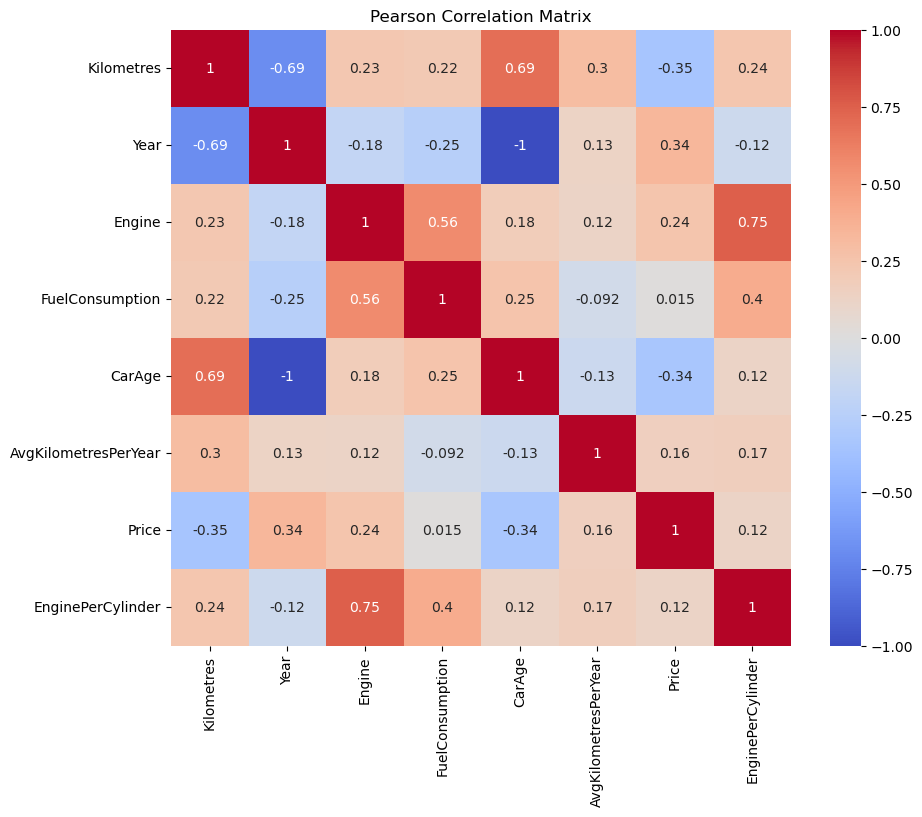

In [152]:
numeric_columns = ['Kilometres', 'Year', 'Engine', 'FuelConsumption', 'CarAge', 'AvgKilometresPerYear', 'Price','EnginePerCylinder']

pearson_corr_matrix = temp_df[numeric_columns].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix')
plt.show()

- Обучим модель Catboost , при помощи randomsearchCV подбирая гиперпараметры

In [154]:
#numeric_columns = ['Kilometres','Year', 'Engine', 'FuelConsumption']
#categorical_columns = df_train.drop(numeric_columns + ['Car/Suv','Price','Title'], axis=1).columns


#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', StandardScaler(), ['Kilometres', 'Year', 'Engine', 'FuelConsumption', 'EnginePerCylinder', 'AvgKilometresPerYear']),
#        ('cat', LabelEncoder(), categorical_columns)
#    ]
#)

#pipeline = Pipeline(steps=[
#    ('transformer', BaseDataTransformer()),
#    ('preprocessor', preprocessor),
#    ('regressor', CatBoostRegressor())
#])

#param_dist = {
#    'transformer__threshold_brands': [0, 2,5, 10, 20, 30,100,190],
#    'transformer__threshold_cylindersin': [2,5,50, 80, 86, 100, 120],
#    'transformer__threshold_models': [2,5,10, 20,40,70],
#    'transformer__num_new_features': [0, 10, 15, 20, 30, 40, 45,  50, 60],
#    'regressor__iterations': randint(2700, 3500),
#    #'regressor__depth': randint(5, 15),
#    #'regressor__learning_rate': [0.01, 0.05, 0.1],
#    #'regressor__l2_leaf_reg': randint(3, 10),
#}

#random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
#                                  n_iter=70, cv=3, n_jobs=-1, scoring='r2',
#                                  verbose=2, random_state=42)

#X_train, y_train = df_train.drop(['Price'], axis=1), df_train['Price']
#X_test, y_test = df_test.drop(['Price'], axis=1), df_test['Price']

#random_search.fit(X_train, y_train)

#print("Лучшие параметры:", random_search.best_params_)



#y_pred = random_search.predict(X_test)

#mse = mean_absolute_error(y_test,y_pred)
#rmse = mse ** 0.5
#r2 = r2_score(y_test, y_pred)


#print(f"MAE: {mae:.3f}")
#print(f"RMSE: {rmse:.3f}")
#print(f"R2: {r2:.3f}")

Несколько раз в RandomSearch выпадал с одинаковыми значениями гиперпараметров помимо 'regressor__iterations': 2763

0.87 {'regressor__iterations': 2763, 'transformer__num_new_features': 60, 'transformer__threshold_brands': 5, 'transformer__threshold_cylindersin': 86, 'transformer__threshold_models': 10

0.86 {'regressor__iterations': 2019, 'transformer__num_new_features': 60, 'transformer__threshold_brands': 5, 'transformer__threshold_cylindersin': 86, 'transformer__threshold_models': 10}

0.83 {'regressor__iterations': 1585, 'transformer__num_new_features': 30, 'transformer__threshold_brands': 0, 'transformer__threshold_cylindersin': 80, 'transformer__threshold_models': 5

Зафиксируем гиперпараметры data transformer'a , значительно увеличим количсевто итераций добавив регуляризацию 

In [244]:
numeric_columns = ['Kilometres','Year', 'Engine', 'FuelConsumption']
categorical_columns = df_train.drop(numeric_columns + ['Car/Suv','Price','Title'], axis=1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Kilometres','Year', 'Engine', 'FuelConsumption','EnginePerCylinder','AvgKilometresPerYear']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline_catboost = Pipeline(steps=[
    ('transformer', BaseDataTransformer(threshold_brands=5,
                                        threshold_cylindersin=90,
                                        threshold_models=10,
                                        num_new_features=15)),
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(task_type="CPU", iterations=30000,verbose=1000,l2_leaf_reg=10))
])

X_train, y_train = df_train.drop(['Price'], axis=1), df_train['Price']
X_test, y_test = df_test.drop(['Price'], axis=1), df_test['Price']

pipeline_catboost.fit(X_train, y_train)

y_pred = pipeline_catboost.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R2: {r2:.5f}")

0:	learn: 36689.7417076	total: 9.21ms	remaining: 4m 36s
1000:	learn: 13629.1347711	total: 4.25s	remaining: 2m 3s
2000:	learn: 9970.3377380	total: 8.28s	remaining: 1m 55s
3000:	learn: 8370.9932829	total: 13.6s	remaining: 2m 2s
4000:	learn: 7446.1803892	total: 17.8s	remaining: 1m 55s
5000:	learn: 6847.3517543	total: 22.5s	remaining: 1m 52s
6000:	learn: 6374.9779177	total: 29s	remaining: 1m 55s
7000:	learn: 6016.5524325	total: 35s	remaining: 1m 55s
8000:	learn: 5717.1730640	total: 40.9s	remaining: 1m 52s
9000:	learn: 5456.2264442	total: 47.1s	remaining: 1m 49s
10000:	learn: 5217.1631239	total: 53.3s	remaining: 1m 46s
11000:	learn: 5012.7708214	total: 59s	remaining: 1m 41s
12000:	learn: 4825.0326344	total: 1m 4s	remaining: 1m 37s
13000:	learn: 4661.5569420	total: 1m 10s	remaining: 1m 31s
14000:	learn: 4523.2045631	total: 1m 15s	remaining: 1m 26s
15000:	learn: 4395.6624216	total: 1m 21s	remaining: 1m 21s
16000:	learn: 4279.8821943	total: 1m 26s	remaining: 1m 15s
17000:	learn: 4169.2524998	t

- Теперь попробуем найти параметры для LGBM

In [160]:
numeric_columns = ['Kilometres','Year', 'Engine', 'FuelConsumption']
categorical_columns = df_train.drop(numeric_columns + ['Car/Suv','Price','Title'], axis=1).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Kilometres','Year', 'Engine', 'FuelConsumption','EnginePerCylinder','AvgKilometresPerYear']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('transformer', BaseDataTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor())
])

param_dist = {
    'transformer__threshold_brands': [0, 2,5, 10, 20, 30,100,190],
    'transformer__threshold_cylindersin': [2,5,50, 80, 86, 100, 120],
    'transformer__threshold_models': [2,5,10, 20,40,70],
    'transformer__num_new_features': [0, 10, 15, 20, 30, 40, 45,  50, 60],
    'regressor__n_estimators': randint(100, 1000), 
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': randint(2, 10),
    'regressor__num_leaves': randint(20, 100),
    'regressor__subsample': [0.5, 0.7, 0.9],
    'regressor__colsample_bytree': [0.5, 0.7, 0.9]
}

random_search_lgbm = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                  n_iter=70, cv=3, n_jobs=-1, scoring='r2',
                                  verbose=2, random_state=42)

X_train, y_train = df_train.drop(['Price'], axis=1), df_train['Price']
X_test, y_test = df_test.drop(['Price'], axis=1), df_test['Price']

random_search_lgbm.fit(X_train, y_train)

print("Лучшие параметры:", random_search_lgbm.best_params_)

y_pred = random_search_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R2: {r2:.5f}")

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 13348, number of used features: 233
[LightGBM] [Info] Start training from score 37255.187743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

- Аналогично для XBBoost

In [162]:
numeric_columns = ['Kilometres','Year', 'Engine', 'FuelConsumption']
categorical_columns = df_train.drop(numeric_columns + ['Car/Suv','Price','Title'], axis=1).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Kilometres','Year', 'Engine', 'FuelConsumption','EnginePerCylinder','AvgKilometresPerYear']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('transformer', BaseDataTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

param_dist = {
    'transformer__threshold_brands': [0, 2, 5, 10, 20, 30, 100, 190],
    'transformer__threshold_cylindersin': [2, 5, 50, 80, 86, 100, 120],
    'transformer__threshold_models': [2, 5, 10, 20, 40, 70],
    'transformer__num_new_features': [0, 10, 15, 20, 30, 40, 45, 50, 60],
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': randint(2, 10),
    'regressor__subsample': [0.5, 0.7, 0.9],
    'regressor__colsample_bytree': [0.5, 0.7, 0.9],
    'regressor__reg_lambda': [0.1, 0.5, 1, 5],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1]
}

random_search_xgb = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                  n_iter=50, cv=3, n_jobs=-1, scoring='r2',
                                  verbose=2, random_state=42)

X_train, y_train = df_train.drop(['Price'], axis=1), df_train['Price']
X_test, y_test = df_test.drop(['Price'], axis=1), df_test['Price']

random_search_xgb.fit(X_train, y_train)

print("Лучшие параметры:", random_search_xgb.best_params_)

y_pred = random_search_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R2: {r2:.5f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'regressor__colsample_bytree': 0.5, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 8, 'regressor__n_estimators': 226, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 5, 'regressor__subsample': 0.5, 'transformer__num_new_features': 0, 'transformer__threshold_brands': 2, 'transformer__threshold_cylindersin': 5, 'transformer__threshold_models': 2}
MAE: 6448.61953
RMSE: 14128.06193
R2: 0.85654


In [163]:
base_models = {'lgbm':random_search_lgbm, 'xgboost': random_search_xgb, 'catboost': pipeline_catboost}

def generate_predictions(models, X):
    predictions = []
    for name, model in models.items():
        preds = model.predict(X)
        predictions.append(preds)
    return np.column_stack(predictions)

X_train_preds = generate_predictions(base_models, X_train)

#meta_model = CatBoostRegressor(random_state=42, verbose=0)
meta_model = RandomForestRegressor(n_estimators=300)
meta_model.fit(X_train_preds, y_train)

X_test_preds = generate_predictions(base_models, X_test)

y_pred = meta_model.predict(X_test_preds)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R2: {r2:.5f}")


MAE: 5072.61161
RMSE: 12654.62166
R2: 0.88490


In [224]:
X_train, y_train = df_train.drop(['Price'], axis=1), df_train['Price']
X_test, y_test = df_test.drop(['Price'], axis=1), df_test['Price']
dt = BaseDataTransformer(threshold_brands=10, threshold_cylindersin=86,threshold_models=10, num_new_features=20)

X_train = dt.fit_transform(X_train)
X_test = dt.transform(X_test)

categorical_columns = df_train.drop(['Kilometres','Year', 'Engine', 'FuelConsumption'] + ['Car/Suv','Price','Title'], axis=1).columns
numeric_columns = ['Kilometres', 'Year', 'Engine', 'FuelConsumption', 'EnginePerCylinder', 'AvgKilometresPerYear']
gfs = GreedyFeatureSelection(iterations=1000)
res_cols, res_cat_cols = gfs.feature_selection(X_train, y_train, X_test, y_test,numeric_columns,categorical_columns)

Количество признаков = 38
--------------------------------------------------
Изучаем колонку Kilometres
Сейчас используются колонки с именами: ['Kilometres']
Learning rate set to 0.061659
0:	learn: 36708.3437844	total: 156ms	remaining: 2m 35s
999:	learn: 32355.1997302	total: 2.6s	remaining: 0us
MAE: 16604.28380
RMSE: 32490.93665
R2: 0.24128
--------------------------------------------------
Изучаем колонку Year
Сейчас используются колонки с именами: ['Kilometres', 'Year']
Learning rate set to 0.061659
0:	learn: 36599.9434841	total: 7.04ms	remaining: 7.03s
999:	learn: 26960.2779061	total: 2.52s	remaining: 0us
MAE: 15544.17532
RMSE: 32615.62760
R2: 0.23544
--------------------------------------------------
Изучаем колонку Engine
Сейчас используются колонки с именами: ['Kilometres', 'Engine']
Learning rate set to 0.061659
0:	learn: 36382.8274640	total: 4.91ms	remaining: 4.91s
999:	learn: 22379.8098581	total: 3.48s	remaining: 0us
MAE: 11809.53574
RMSE: 25512.90817
R2: 0.53218
-------------

Используя атрибут logs выведем получившиеся параметры

In [226]:
gfs.logs

{'best_features': ['Kilometres',
  'Engine',
  'FuelConsumption',
  'EnginePerCylinder',
  'AvgKilometresPerYear',
  'Brand',
  'Model',
  'DriveType'],
 'best_categorical_cols': ['Brand', 'Model', 'DriveType'],
 'best_numeric_cols': ['Kilometres',
  'Engine',
  'FuelConsumption',
  'EnginePerCylinder',
  'AvgKilometresPerYear'],
 'best_r2_score': 0.8371154873127304}

In [243]:
from catboost import CatBoostRegressor, Pool
categorical_columns = df_train.drop(['Kilometres','Year', 'Engine', 'FuelConsumption'] + ['Car/Suv','Price','Title'], axis=1).columns
numeric_columns = ['Kilometres', 'Year', 'Engine', 'FuelConsumption', 'EnginePerCylinder', 'AvgKilometresPerYear']

all = gfs.logs['best_features']
cat = gfs.logs['best_categorical_cols']
numeric_columns_new = gfs.logs['best_numeric_cols']

X_train, y_train = df_train.drop(['Price'], axis=1), df_train['Price']
X_test, y_test = df_test.drop(['Price'], axis=1), df_test['Price']

transformer = BaseDataTransformer(threshold_brands=5, threshold_cylindersin=86, threshold_models=10, num_new_features=20)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
    ],
            remainder='passthrough'
)
new_features_categorical = list(X_train.drop(numeric_columns,axis=1).columns)
full_cols_names = numeric_columns + new_features_categorical

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = pd.DataFrame(X_train,columns=full_cols_names)
X_test = pd.DataFrame(X_test,columns=full_cols_names)

train_pool = Pool(data=X_train[all],
                          label=y_train,
                          cat_features=cat) 
test_pool = Pool(data=X_test[all], cat_features=cat)
regressor = CatBoostRegressor(task_type="CPU", iterations=10000,verbose=100,l2_leaf_reg=10)

regressor.fit(train_pool)
          
y_pred = regressor.predict(test_pool)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"R2: {r2:.5f}")

0:	learn: 36766.6544526	total: 79.6ms	remaining: 13m 15s
100:	learn: 24522.5586785	total: 8.15s	remaining: 13m 18s
200:	learn: 22488.8779885	total: 15.5s	remaining: 12m 38s
300:	learn: 21183.0369010	total: 22.7s	remaining: 12m 10s
400:	learn: 20357.6576065	total: 30.3s	remaining: 12m 5s
500:	learn: 19619.9953911	total: 38.4s	remaining: 12m 7s
600:	learn: 18951.5541530	total: 46.1s	remaining: 12m
700:	learn: 18314.4417007	total: 54.1s	remaining: 11m 57s
800:	learn: 17671.6048769	total: 1m 1s	remaining: 11m 48s
900:	learn: 17114.3243483	total: 1m 9s	remaining: 11m 39s
1000:	learn: 16651.7459134	total: 1m 16s	remaining: 11m 29s
1100:	learn: 16162.3102578	total: 1m 25s	remaining: 11m 27s
1200:	learn: 15688.2305464	total: 1m 33s	remaining: 11m 23s
1300:	learn: 15325.0377479	total: 1m 41s	remaining: 11m 16s
1400:	learn: 14981.6015984	total: 1m 49s	remaining: 11m 11s
1500:	learn: 14652.4781416	total: 1m 57s	remaining: 11m 3s
1600:	learn: 14244.0249882	total: 2m 4s	remaining: 10m 53s
1700:	lea